# Clustering clients and predicting booking cancellations with Machine Learning

This data set contains a single file which compares various booking information between two hotels: a city hotel and a resort hotel. Both hotels are located in Portugal (southern Europe).
The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".

Today, many hotels are trying to categorize their customers such as their needs, wants, characteristics in order to approach them in the most effective way.\
In data analysis, this can be possible by clustering clients with unsupervised machine learning algorithms. 

Another challenge for hotels is to be able to identify in advance customers who are going to cancel their reservation. By knowing this information, they can better plan personel and food requirements for instance. 

We will follow this process:
- Data cleaning
- Exploratory data analysis
- Unsupervised learning - clustering booking clients 
- Supervised learning - predicting cancellations
- Summary

In [133]:
# importing librairies

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
import shap
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from umap import UMAP
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 1. Data Cleaning

In [134]:
df = pd.read_csv('/Users/borispetelle/Documents/GitHub/BOOKING PROJECT/hotel_bookings.csv')

In [135]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Let's first check if we have missing values

In [136]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [137]:
# Replacing with 0 missing values for children
df.children.fillna(0, inplace=True)

# Keeping only the 5th most important countries, creating new catogories "Other Europe" and "Other"
df.country = df.country.apply(lambda x : 
                 x if x in ['PRT','GBR','ESP','FRA','DEU'] else 
                              ("Other_EU" if x in ['ITA','IRL','BEL','NLD','CHE','AUT','SWE','POL','NOR','ROU','FIN','DNK','LUX','HUN'] 
                               else "Other"))

# As the ID of the agency is not relevant, we will just put 1 if the client made his reservation via an agency
df.agent = df.agent.apply(lambda x: 0 if math.isnan(x) else 1 )

# As the ID of the company is not relevant, we will just put 1 if it was a company that made the reservation
df.company = df.company.apply(lambda x: 0 if math.isnan(x) else 1 )

# Merging Undefined and SC (Self Catering) as both are saying the same thing : 'No meal'
df.meal = df.meal.apply(lambda x : "No_meal" if x in ['SC','Undefined'] else x)

# Dropping rows with undifined distrubution channel and market_segment
df.drop(df[df.distribution_channel == 'Undefined'].index, inplace=True)
df.reset_index()

# Dropping rows whith booking containing more than 10 peoples (assuming it is a mistake while doing the reservation)
df.drop(df[df.adults>10].index, inplace=True)
df.reset_index()

# Droping the booking with 10 childrens (assuming it is a mistake while doing the reservation)
df.drop(df[df.children==10].index, inplace=True)
df.reset_index()

# Dropping the 3 bookings with more than 8 babies (assuming it is a mistake while doing the reservation)
df.drop(df[df.babies>8].index, inplace=True)
df.reset_index()

# Dropping two adr outliers = 5400 & inferior at 0(assuming it is a mistake while doing the reservation)
df.drop(df[(df.adr==5400)].index, inplace=True)
df.drop(df[(df.adr<0)].index, inplace=True)
df.reset_index()

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,0,0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,...,No Deposit,0,0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,...,No Deposit,0,0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,...,No Deposit,1,0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,...,No Deposit,1,0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119363,119385,City Hotel,0,23,2017,August,35,30,2,5,...,No Deposit,1,0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119364,119386,City Hotel,0,102,2017,August,35,31,2,5,...,No Deposit,1,0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119365,119387,City Hotel,0,34,2017,August,35,31,2,5,...,No Deposit,1,0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119366,119388,City Hotel,0,109,2017,August,35,31,2,5,...,No Deposit,1,0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [138]:
df.shape

(119368, 32)

In [139]:
df1 = df.copy()

# 2. Exploratory data analysis

# 2.1 Data visualization

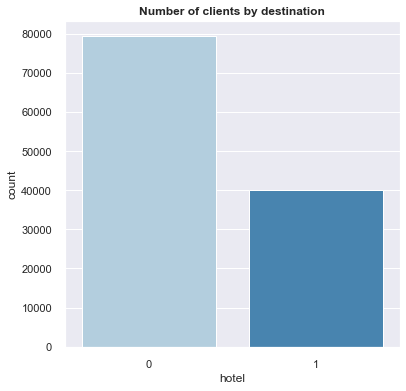

In [185]:
plt.figure(figsize=(6,6))
sns.countplot(x='hotel', data=df1, palette='Blues').set_title('Number of clients by destination',fontweight='bold')
plt.show()

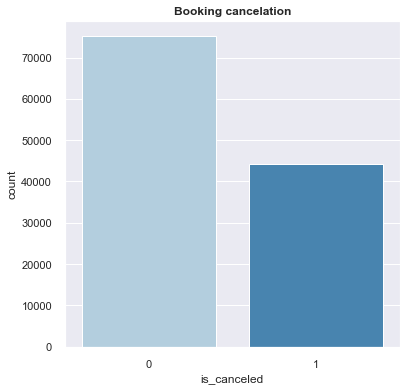

In [146]:
plt.figure(figsize=(6,6))
sns.countplot(x='is_canceled', data=df1, palette='Blues').set_title('Booking cancelation',fontweight='bold')
plt.show()

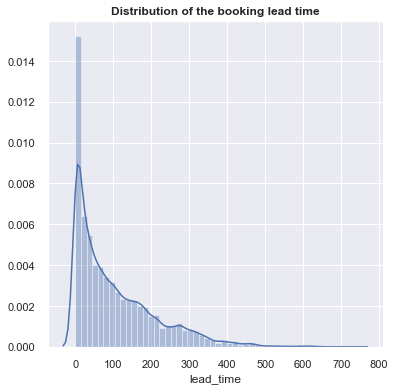

In [144]:
plt.figure(figsize=(6,6))
sns.distplot(df1.lead_time).set_title('Distribution of the booking lead time',fontweight='bold')
plt.show()

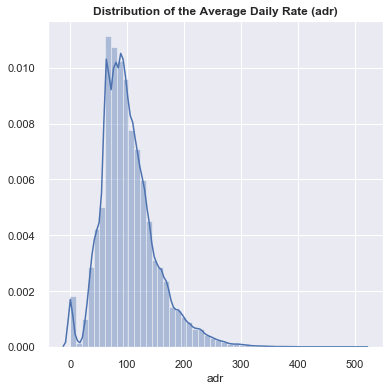

In [145]:
plt.figure(figsize=(6,6))
sns.distplot(df1.adr).set_title('Distribution of the Average Daily Rate (adr)',fontweight='bold')
plt.show()

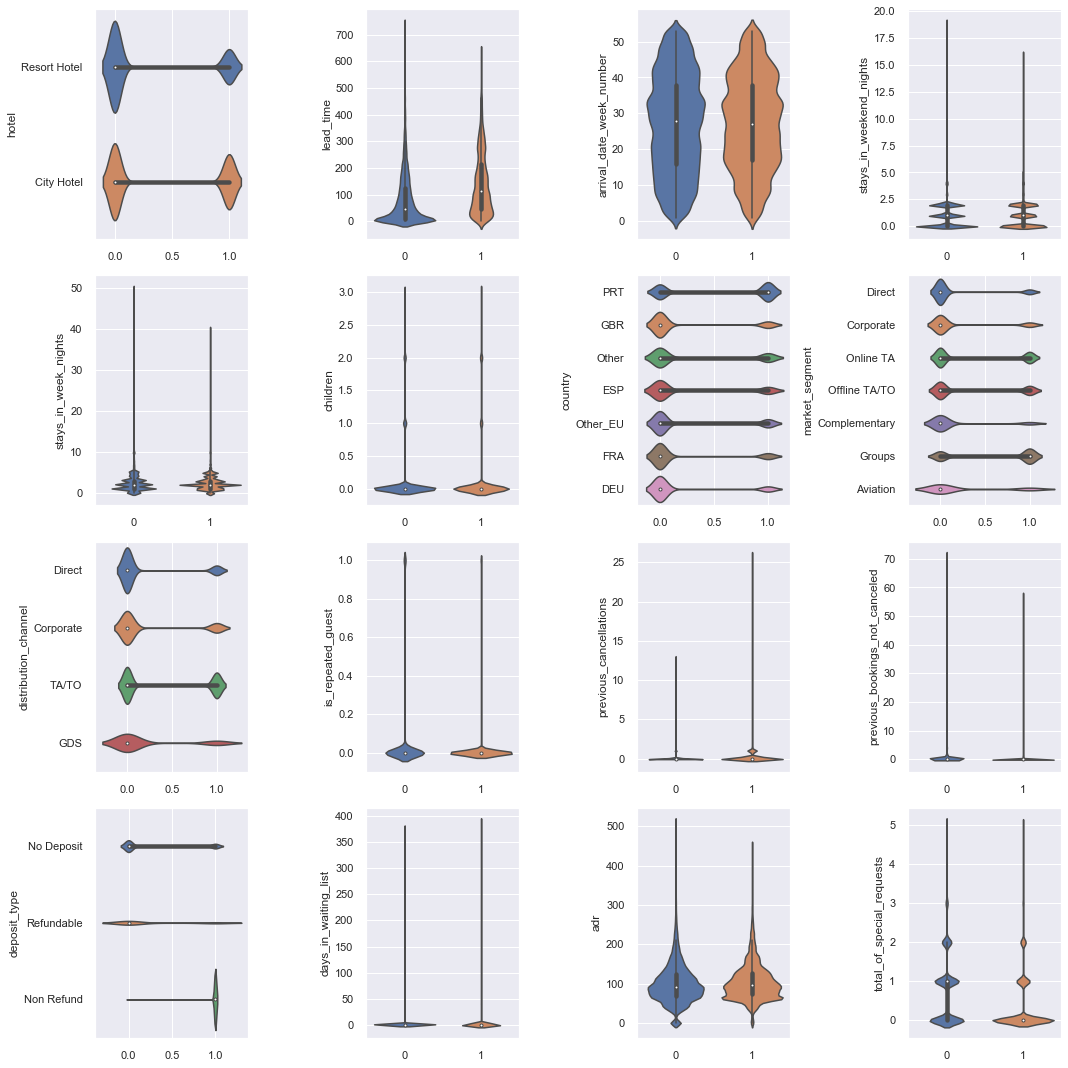

In [147]:
numerical = ['hotel', 'lead_time','arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'children', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled','deposit_type', 'days_in_waiting_list', 'adr','total_of_special_requests']
fig, axes=plt.subplots(nrows=4, ncols=4, figsize=(15,15))
for idx, feat in enumerate(numerical):
    ax=axes[int(idx/4), idx%4]
    sns.violinplot(x='is_canceled',y=feat, data=df, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout();

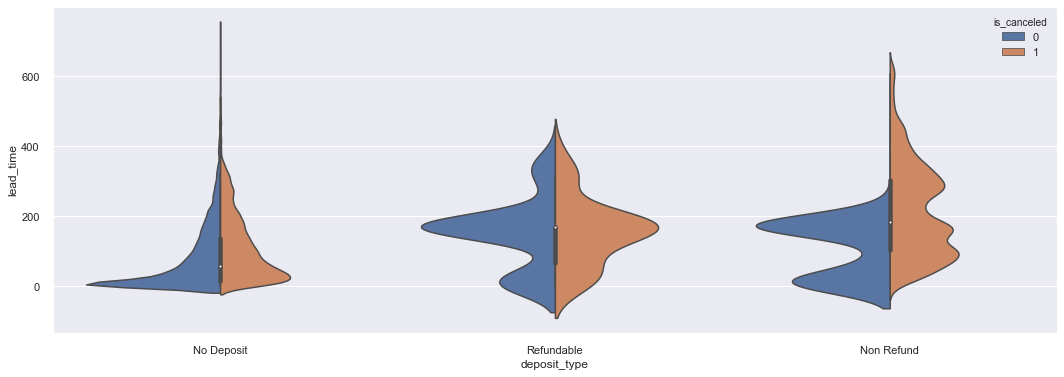

In [148]:
plt.figure(figsize=(18,6))
sns.violinplot(x='deposit_type', y='lead_time', hue='is_canceled', data=df1, split=True)
plt.show()

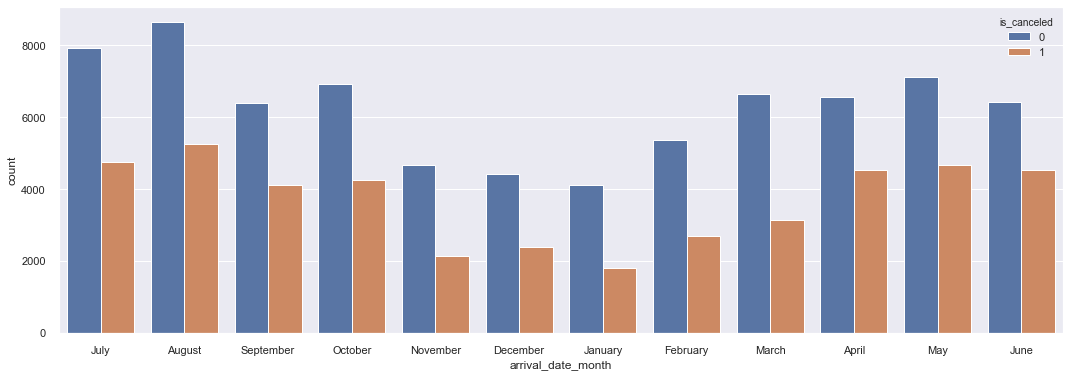

In [149]:
plt.figure(figsize=(18,6))
sns.countplot(x='arrival_date_month', hue='is_canceled', data=df1)
plt.show()

# 2.2 Data manipulation

In order to apply models to our data, we have to transform all our data in numerical data.

In [150]:
# Transforming resort hotel = 1 and city hostel = 0
df1['hotel'] = df1.hotel.apply(lambda x : 1 if x == "Resort Hotel" else 0)

# Transforming month into interger values
df1.arrival_date_month = df1.arrival_date_month.map({'January':1, 'February': 2, 'March':3, 'April':4,'May':5, 
                                                     'June':6, 'July':7,'August':8, 'September':9, 'October':10, 
                                                     'November':11, 'December':12})


# Creating dummies for multi-value features
df1 = pd.get_dummies(df1, columns = ['meal','country','market_segment','distribution_channel','deposit_type',
                                     'customer_type','reserved_room_type','arrival_date_year'], drop_first=True) 

# 2.3 Correlation matrix

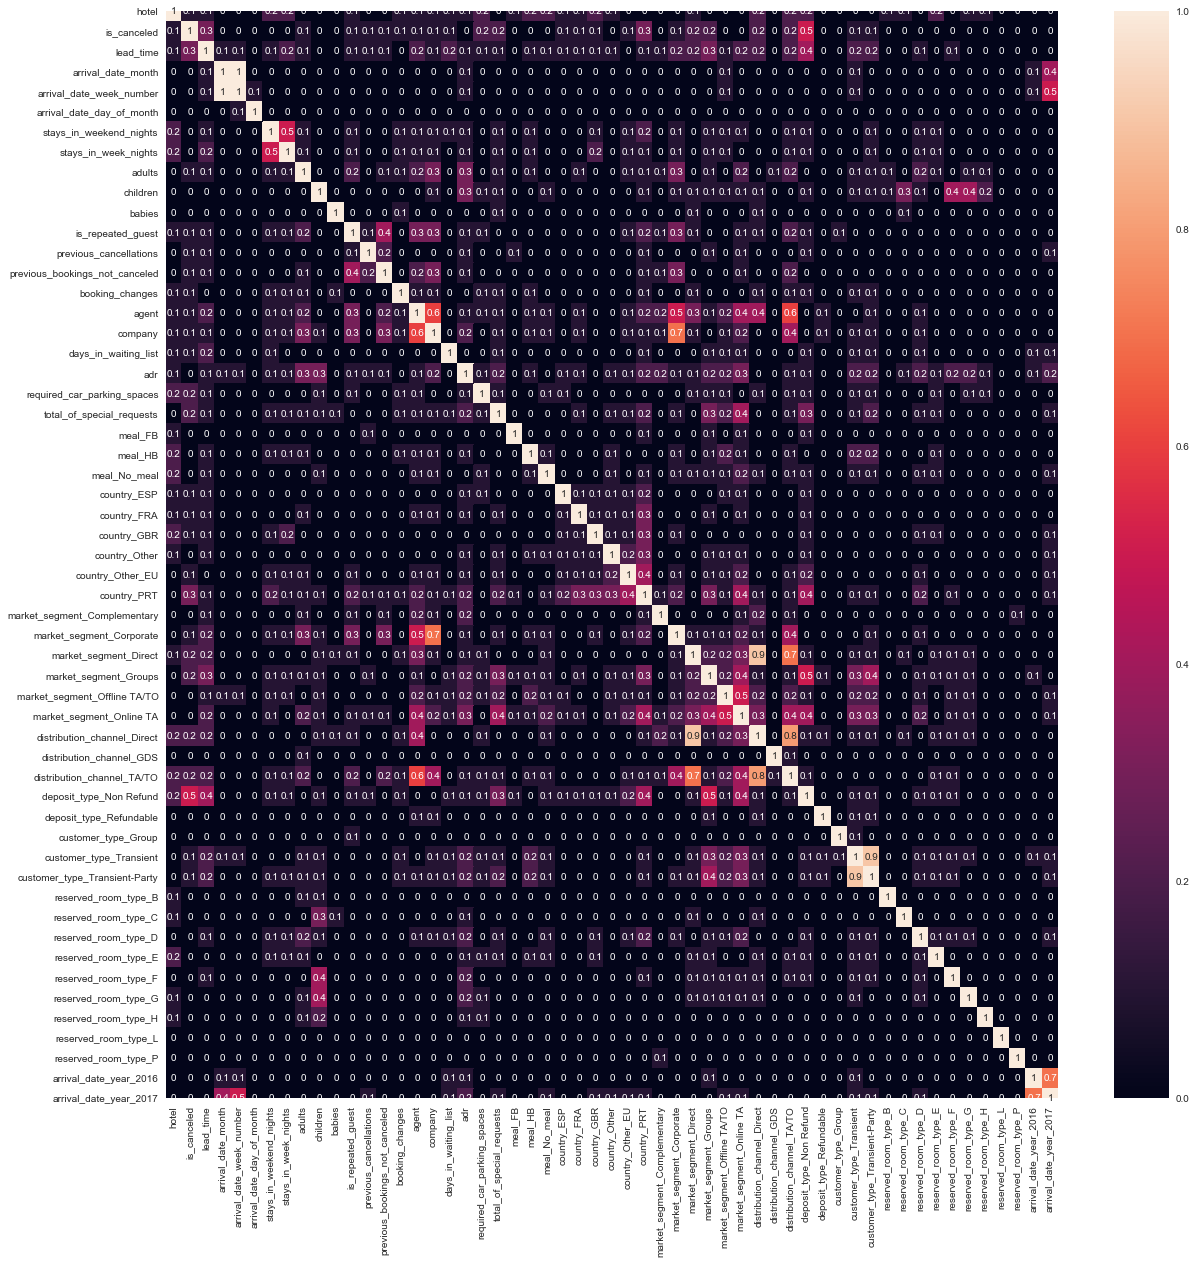

In [12]:
plt.figure(figsize=(20,20))
corr_heatmap = sns.heatmap(abs(df1.corr()).round(1),annot=True)
plt.show()

Columns that are correlated are the following:
- distribution_channel_Direct with market_segment_Direct 
- customer_type_Transient with customer_type_Transient-Party
- arrival_date_week_number with arrival_date_month

For the modelisation part, I will drop 'distribution_channel_Direct', 'customer_type_Transient-Party' and 'arrival_date_month'

In [151]:
df2 = df1.copy()

# 3. Clustering

The main objective is to first cluster the client. Let's take all columns that are only related to the client.

In [152]:
# Columns to take into account
df_cluster = df2[['adults','children',"babies",'country_ESP', 'country_FRA', 'country_GBR','country_Other', 
                  'country_Other_EU', 'country_PRT','is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled']]

We have two columns that are not in the same scale. Let's standardize them.

In [153]:
def minmax(x):
    return (x-x.min())/(x.max()-x.min())

In [154]:
df_cluster[["previous_cancellations","previous_bookings_not_canceled"]]=df_cluster[["previous_cancellations","previous_bookings_not_canceled"]].apply(minmax)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 3.1 KMeans model with PCA

In [155]:
pca = PCA(0.85)
pca.fit(df_cluster)
pca.explained_variance_ratio_

array([0.27194814, 0.18979034, 0.13606579, 0.12175893, 0.09255253,
       0.08029481])

In [156]:
pca_df = pd.DataFrame(pca.transform(df_cluster), columns=['pca1','pca2','pca3','pca4','pca5','pca6'])

In [157]:
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6
0,-0.489619,0.444075,-0.042452,0.051539,-0.026881,-0.022692
1,-0.489619,0.444075,-0.042452,0.051539,-0.026881,-0.022692
2,-0.070098,-0.930757,-0.159947,-0.373869,0.711904,-0.441896
3,-0.070098,-0.930757,-0.159947,-0.373869,0.711904,-0.441896
4,0.418269,-0.062624,-0.195813,-0.373649,0.671217,-0.474658


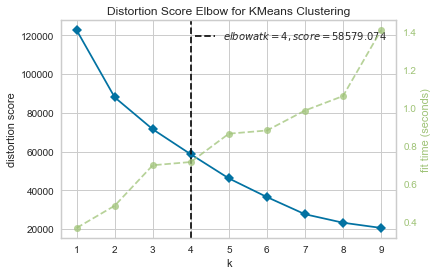

In [317]:
# To find the optimal number of KMeans 
visualizer = KElbowVisualizer(df_clusters,k=(1,10))
visualizer.fit(pca_df)
visualizer.poof()

In [158]:
# From the visualization above, we can see that the optimum KMeans is 4
kmeans = KMeans(4)
df_clusters = kmeans.fit(pca_df)
df_clusters.cluster_centers_

array([[-0.46415875,  0.47413173,  0.04430198,  0.05367689, -0.02249459,
        -0.02429275],
       [ 0.55755548, -0.22584306, -0.05078511,  0.73505781, -0.06708491,
        -0.06436091],
       [ 0.4455371 ,  0.01286223, -0.01481009, -0.31763754,  0.04521987,
         0.04079137],
       [-0.64338706, -0.6435904 ,  0.00074652, -0.09491398,  0.00497244,
         0.01494251]])

In [159]:
# Putting the clusters associated in a column 'cluster' in our dataframe 
df_cluster['cluster']=df_clusters.fit_predict(pca_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [160]:
# Repartition of the clusters
df_cluster.cluster.value_counts()

1    48568
3    38399
2    19029
0    13372
Name: cluster, dtype: int64

# 3.2 Evaluation of metrics & visualization of clusters

We can evaluate the clustering with the silhouette and davies bouldin scores.

In [238]:
# Positive  = well-separated clusters
a = df_cluster.drop('cluster',axis=1).copy()
silhouette_score(a,df_cluster['cluster'])

0.4791199110611393

In [241]:
# the lower, the better 
davies_bouldin_score(a,df_cluster['cluster'])

1.2969697896623047

There are not optimal but let's understand what clusters we have built.

In [183]:
# Groupby to compare the means
scaler = MinMaxScaler().fit_transform(df_group)
df_heat = pd.DataFrame(scaler, columns = df_group.columns)

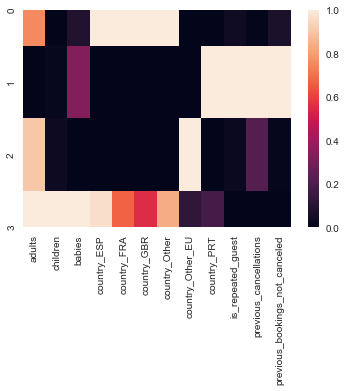

In [184]:
sns.heatmap(df_heat)

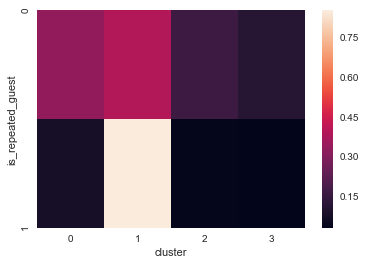

In [185]:
sns.heatmap(pd.crosstab(df_cluster.is_repeated_guest, df_cluster.cluster, normalize='index'))

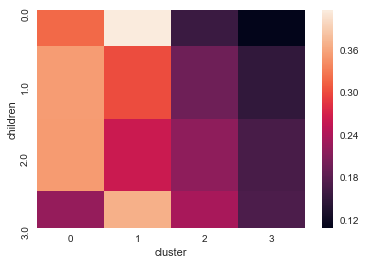

In [186]:
sns.heatmap(pd.crosstab(df_cluster.children, df_cluster.cluster, normalize='index'))

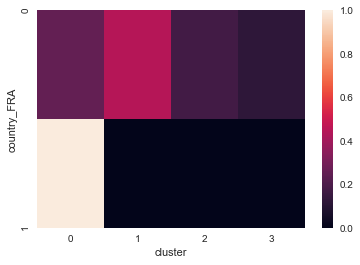

In [187]:
sns.heatmap(pd.crosstab(df_cluster.country_FRA, df_cluster.cluster, normalize='index'))

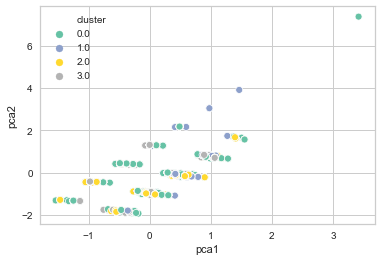

In [288]:
sns.scatterplot(x='pca1',y='pca2', data=pca_df, hue=df_cluster.cluster, palette='Set2')

Visualization with PCA is not very convincing, let's see if we can better visualize it with UMAP.

# 3.2 Visualization with UMAP


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/anaconda3/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^


The keyword argument 'parallel=True' was specified but no transformation for parallel exec

ValueError: 'c' argument has 119369 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

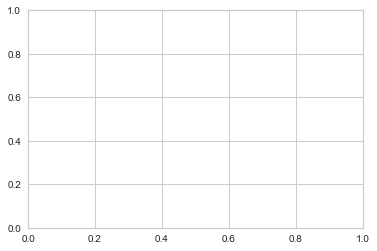

In [37]:
reducer = UMAP()
embedding = reducer.fit_transform(df_cluster.drop('cluster',axis=1))

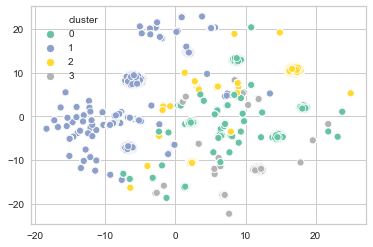

In [287]:
sns.scatterplot(embedding[:,0],embedding[:,1], hue=df_cluster.cluster, palette='Set2')

# 3.2 KMEANS Without PCA

Let's check if we could obtain better results without PCA.

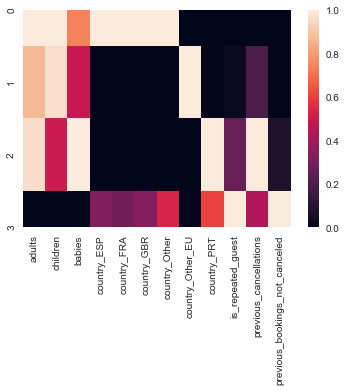

In [284]:
clients_cluster = KMeans(4)
clients_cluster.fit(a)

a['labels']= clients_cluster.labels_

df_group = a.groupby('labels').agg(np.mean)

scaler = MinMaxScaler().fit_transform(df_group)
df_heat = pd.DataFrame(scaler, columns = df_group.columns)

sns.heatmap(df_heat)

In [285]:
a.columns

Index(['adults', 'children', 'babies', 'country_ESP', 'country_FRA',
       'country_GBR', 'country_Other', 'country_Other_EU', 'country_PRT',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'labels'],
      dtype='object')

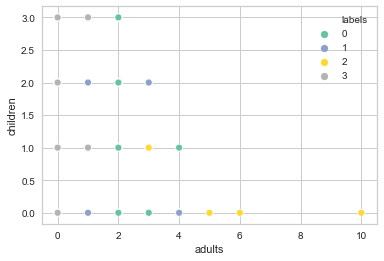

In [300]:
sns.scatterplot(x=a.adults,y=a.children,hue=a.labels,palette='Set2')

# 4. Modeling

In [161]:
# Putting the clusters in a new column of our original dataframe
df2['client_cluster'] = df_cluster.cluster

In [162]:
df3 = df2.copy()

In [163]:
X = df3.drop(['adults','children',"babies",'country_ESP', 'country_FRA', 'country_GBR','country_Other', 
              'country_Other_EU', 'country_PRT','is_repeated_guest', 'previous_cancellations', 
              'previous_bookings_not_canceled','is_canceled',"assigned_room_type", "reservation_status", "reservation_status_date","distribution_channel_Direct",
                 "customer_type_Transient-Party","arrival_date_month","booking_changes"],axis=1)

y = df3.is_canceled

In [164]:
#Standardizing some columns to have the same sclae
columns_scaler = ["lead_time","stays_in_weekend_nights","stays_in_week_nights","adr","days_in_waiting_list"]
X[columns_scaler]=X[columns_scaler].apply(minmax)

In [165]:
# Spliting data into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

# 4.1 Logistic Regression

In [166]:
# Model 1 

model1 = LogisticRegression(class_weight='balanced',max_iter=2000).fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

The confusion matrix is: 
 [[19987  4817]
 [ 4190 10398]]
The auc score is:  0.759
The accuracy score is:  0.771
The recall score is:  0.713
The precision score is:  0.683
F1 score is:  0.698


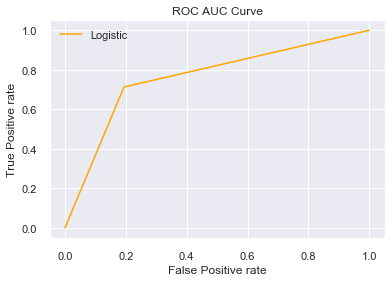

In [167]:
# Metrics for Model 1

confusion_matrix1 = confusion_matrix(y_test,y_pred1)
print("The confusion matrix is: \n", confusion_matrix1)
fpr,tpr,thresholds = roc_curve(y_test,y_pred1)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc1 = roc_auc_score(y_test,y_pred1)
print("The auc score is: ",roc_auc1.round(3))

accuracy1 = accuracy_score(y_test,y_pred1)
print("The accuracy score is: ", accuracy1.round(3))

recall1 = recall_score(y_test,y_pred1)
print("The recall score is: ", recall1.round(3))

precision1 = precision_score(y_test,y_pred1)
print("The precision score is: ", precision1.round(3))

f1_score1 = f1_score(y_test,y_pred1)
print("F1 score is: ", f1_score1.round(3))

# 4.2 K Nearest Neighbors with hyperparameters tuning and cross validation

In [168]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import datasets as skd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

X,y = skd.make_classification(n_samples=10000, n_features=2, n_redundant=0, random_state=4)

model=KNeighborsClassifier()

params={'n_neighbors':range(1,21,2), 'weights':['uniform','distance'], \
        'metric':['manhattan','minkowski']}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

grid_search1=GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, scoring='f1', cv=cv)
grid_search1.fit(X,y)
print(f'Best {grid_search1.best_score_} using {grid_search1.best_params_}')

Best 0.9060379833874848 using {'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'distance'}


In [169]:
# Model 2

model2 =  KNeighborsClassifier(metric='minkowski', n_neighbors=17, weights='distance').fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

The confusion matrix is: 
 [[22084  2720]
 [ 3874 10714]]
The auc score is:  0.812
The accuracy score is:  0.833
The recall score is:  0.734
The precision score is:  0.798
F1 score is:  0.765


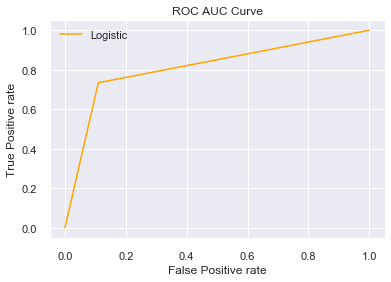

In [170]:
# Metrics for model 2 

confusion_matrix2 = confusion_matrix(y_test,y_pred2)
print("The confusion matrix is: \n", confusion_matrix2)
fpr,tpr,thresholds = roc_curve(y_test,y_pred2)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc2 = roc_auc_score(y_test,y_pred2)
print("The auc score is: ",roc_auc2.round(3))

accuracy2 = accuracy_score(y_test,y_pred2)
print("The accuracy score is: ", accuracy2.round(3))

recall2 = recall_score(y_test,y_pred2)
print("The recall score is: ", recall2.round(3))

precision2 = precision_score(y_test,y_pred2)
print("The precision score is: ", precision2.round(3))

f1_score2 = f1_score(y_test,y_pred2)
print("F1 score is: ", f1_score2.round(3))

# 4.3 Decision Tree Classifier

In [171]:
# Model 3

model3 = DecisionTreeClassifier(class_weight='balanced').fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

The confusion matrix is: 
 [[21672  3132]
 [ 3117 11471]]
The auc score is:  0.83
The accuracy score is:  0.841
The recall score is:  0.786
The precision score is:  0.786
F1 score is:  0.786


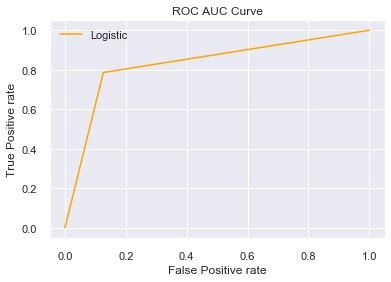

In [172]:
# Metrics for Model 3

confusion_matrix3 = confusion_matrix(y_test,y_pred3)
print("The confusion matrix is: \n", confusion_matrix3)
fpr,tpr,thresholds = roc_curve(y_test,y_pred3)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc3 = roc_auc_score(y_test,y_pred3)
print("The auc score is: ",roc_auc3.round(3))

accuracy3 = accuracy_score(y_test,y_pred3)
print("The accuracy score is: ", accuracy3.round(3))

recall3 = recall_score(y_test,y_pred3)
print("The recall score is: ", recall3.round(3))

precision3 = precision_score(y_test,y_pred3)
print("The precision score is: ", precision3.round(3))

f1_score3 = f1_score(y_test,y_pred3)
print("F1 score is: ", f1_score3.round(3))

# 4.4 Random Forest Classifier

In [173]:
# Model 4
model4 = RandomForestClassifier().fit(X_train, y_train)
y_pred4 = model4.predict(X_test)

The confusion matrix is: 
 [[23064  1740]
 [ 3030 11558]]
The auc score is:  0.861
The accuracy score is:  0.879
The recall score is:  0.792
The precision score is:  0.869
F1 score is:  0.829


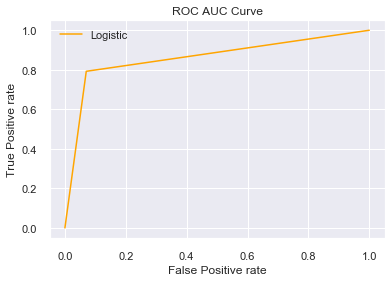

In [174]:
# Metrics for Model 4

confusion_matrix4 = confusion_matrix(y_test,y_pred4)
print("The confusion matrix is: \n", confusion_matrix4)
fpr,tpr,thresholds = roc_curve(y_test,y_pred4)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc4 = roc_auc_score(y_test,y_pred4)
print("The auc score is: ",roc_auc4.round(3))

accuracy4 = accuracy_score(y_test,y_pred4)
print("The accuracy score is: ", accuracy4.round(3))

recall4 = recall_score(y_test,y_pred4)
print("The recall score is: ", recall4.round(3))

precision4 = precision_score(y_test,y_pred4)
print("The precision score is: ", precision4.round(3))

f1_score4 = f1_score(y_test,y_pred4)
print("F1 score is: ", f1_score4.round(3))

# 4.5 Naive Bayes

In [175]:
model5 = GaussianNB().fit(X_train, y_train)
y_pred5 = model5.predict(X_test)

The confusion matrix is: 
 [[10165 14639]
 [ 1988 12600]]
The auc score is:  0.637
The accuracy score is:  0.578
The recall score is:  0.864
The precision score is:  0.463
F1 score is:  0.602


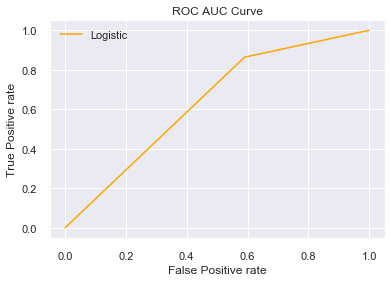

In [176]:
# Metrics for Model 5

confusion_matrix5 = confusion_matrix(y_test,y_pred5)
print("The confusion matrix is: \n", confusion_matrix5)
fpr,tpr,thresholds = roc_curve(y_test,y_pred5)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc5 = roc_auc_score(y_test,y_pred5)
print("The auc score is: ",roc_auc5.round(3))

accuracy5 = accuracy_score(y_test,y_pred5)
print("The accuracy score is: ", accuracy5.round(3))

recall5 = recall_score(y_test,y_pred5)
print("The recall score is: ", recall5.round(3))

precision5 = precision_score(y_test,y_pred5)
print("The precision score is: ", precision5.round(3))

f1_score5 = f1_score(y_test,y_pred5)
print("F1 score is: ", f1_score5.round(3))

# 4.6 Catboost

In [177]:
model6 = CatBoostClassifier().fit(X_train, y_train)
y_pred6 = model6.predict(X_test)

Learning rate set to 0.066911
0:	learn: 0.6308536	total: 193ms	remaining: 3m 12s
1:	learn: 0.5828157	total: 215ms	remaining: 1m 47s
2:	learn: 0.5481606	total: 236ms	remaining: 1m 18s
3:	learn: 0.5212109	total: 258ms	remaining: 1m 4s
4:	learn: 0.4974051	total: 280ms	remaining: 55.7s
5:	learn: 0.4803762	total: 305ms	remaining: 50.6s
6:	learn: 0.4687820	total: 326ms	remaining: 46.2s
7:	learn: 0.4575745	total: 347ms	remaining: 43.1s
8:	learn: 0.4446505	total: 370ms	remaining: 40.7s
9:	learn: 0.4374845	total: 395ms	remaining: 39.1s
10:	learn: 0.4288887	total: 423ms	remaining: 38.1s
11:	learn: 0.4231571	total: 448ms	remaining: 36.9s
12:	learn: 0.4170923	total: 471ms	remaining: 35.8s
13:	learn: 0.4126870	total: 514ms	remaining: 36.2s
14:	learn: 0.4091269	total: 537ms	remaining: 35.3s
15:	learn: 0.4058659	total: 560ms	remaining: 34.4s
16:	learn: 0.4024273	total: 585ms	remaining: 33.8s
17:	learn: 0.4002817	total: 613ms	remaining: 33.5s
18:	learn: 0.3967036	total: 634ms	remaining: 32.7s
19:	lear

164:	learn: 0.3298093	total: 4.25s	remaining: 21.5s
165:	learn: 0.3295841	total: 4.27s	remaining: 21.5s
166:	learn: 0.3294907	total: 4.29s	remaining: 21.4s
167:	learn: 0.3292972	total: 4.31s	remaining: 21.4s
168:	learn: 0.3291721	total: 4.33s	remaining: 21.3s
169:	learn: 0.3290516	total: 4.36s	remaining: 21.3s
170:	learn: 0.3287510	total: 4.38s	remaining: 21.3s
171:	learn: 0.3285918	total: 4.41s	remaining: 21.2s
172:	learn: 0.3284783	total: 4.43s	remaining: 21.2s
173:	learn: 0.3283625	total: 4.45s	remaining: 21.1s
174:	learn: 0.3282254	total: 4.47s	remaining: 21.1s
175:	learn: 0.3280533	total: 4.5s	remaining: 21s
176:	learn: 0.3278746	total: 4.52s	remaining: 21s
177:	learn: 0.3276731	total: 4.55s	remaining: 21s
178:	learn: 0.3275592	total: 4.57s	remaining: 21s
179:	learn: 0.3274303	total: 4.59s	remaining: 20.9s
180:	learn: 0.3272294	total: 4.62s	remaining: 20.9s
181:	learn: 0.3270561	total: 4.64s	remaining: 20.8s
182:	learn: 0.3268775	total: 4.66s	remaining: 20.8s
183:	learn: 0.3267380

328:	learn: 0.3083089	total: 8.09s	remaining: 16.5s
329:	learn: 0.3082147	total: 8.12s	remaining: 16.5s
330:	learn: 0.3081217	total: 8.14s	remaining: 16.5s
331:	learn: 0.3080320	total: 8.16s	remaining: 16.4s
332:	learn: 0.3079487	total: 8.19s	remaining: 16.4s
333:	learn: 0.3078641	total: 8.21s	remaining: 16.4s
334:	learn: 0.3078265	total: 8.24s	remaining: 16.4s
335:	learn: 0.3077327	total: 8.26s	remaining: 16.3s
336:	learn: 0.3075930	total: 8.29s	remaining: 16.3s
337:	learn: 0.3075154	total: 8.32s	remaining: 16.3s
338:	learn: 0.3074278	total: 8.34s	remaining: 16.3s
339:	learn: 0.3072589	total: 8.37s	remaining: 16.2s
340:	learn: 0.3071613	total: 8.39s	remaining: 16.2s
341:	learn: 0.3070922	total: 8.41s	remaining: 16.2s
342:	learn: 0.3069911	total: 8.44s	remaining: 16.2s
343:	learn: 0.3068515	total: 8.46s	remaining: 16.1s
344:	learn: 0.3067612	total: 8.48s	remaining: 16.1s
345:	learn: 0.3066766	total: 8.51s	remaining: 16.1s
346:	learn: 0.3066158	total: 8.53s	remaining: 16.1s
347:	learn: 

487:	learn: 0.2950307	total: 12.6s	remaining: 13.2s
488:	learn: 0.2949175	total: 12.6s	remaining: 13.2s
489:	learn: 0.2948395	total: 12.6s	remaining: 13.1s
490:	learn: 0.2947179	total: 12.6s	remaining: 13.1s
491:	learn: 0.2945939	total: 12.7s	remaining: 13.1s
492:	learn: 0.2945393	total: 12.7s	remaining: 13.1s
493:	learn: 0.2944645	total: 12.7s	remaining: 13s
494:	learn: 0.2944138	total: 12.7s	remaining: 13s
495:	learn: 0.2943765	total: 12.8s	remaining: 13s
496:	learn: 0.2943099	total: 12.8s	remaining: 12.9s
497:	learn: 0.2942445	total: 12.8s	remaining: 12.9s
498:	learn: 0.2942064	total: 12.8s	remaining: 12.9s
499:	learn: 0.2941479	total: 12.9s	remaining: 12.9s
500:	learn: 0.2940786	total: 12.9s	remaining: 12.8s
501:	learn: 0.2940524	total: 12.9s	remaining: 12.8s
502:	learn: 0.2939917	total: 12.9s	remaining: 12.8s
503:	learn: 0.2939318	total: 12.9s	remaining: 12.7s
504:	learn: 0.2938712	total: 13s	remaining: 12.7s
505:	learn: 0.2938143	total: 13s	remaining: 12.7s
506:	learn: 0.2937529	

652:	learn: 0.2842719	total: 17.4s	remaining: 9.24s
653:	learn: 0.2841965	total: 17.4s	remaining: 9.21s
654:	learn: 0.2841451	total: 17.4s	remaining: 9.18s
655:	learn: 0.2840401	total: 17.5s	remaining: 9.15s
656:	learn: 0.2839767	total: 17.5s	remaining: 9.12s
657:	learn: 0.2839331	total: 17.5s	remaining: 9.1s
658:	learn: 0.2838913	total: 17.5s	remaining: 9.08s
659:	learn: 0.2838376	total: 17.6s	remaining: 9.06s
660:	learn: 0.2837945	total: 17.6s	remaining: 9.04s
661:	learn: 0.2837418	total: 17.7s	remaining: 9.02s
662:	learn: 0.2836846	total: 17.7s	remaining: 9s
663:	learn: 0.2836375	total: 17.7s	remaining: 8.98s
664:	learn: 0.2835811	total: 17.8s	remaining: 8.96s
665:	learn: 0.2835292	total: 17.8s	remaining: 8.93s
666:	learn: 0.2834884	total: 17.9s	remaining: 8.91s
667:	learn: 0.2834331	total: 17.9s	remaining: 8.89s
668:	learn: 0.2833358	total: 17.9s	remaining: 8.87s
669:	learn: 0.2832561	total: 18s	remaining: 8.85s
670:	learn: 0.2831830	total: 18s	remaining: 8.82s
671:	learn: 0.283140

815:	learn: 0.2756036	total: 22s	remaining: 4.97s
816:	learn: 0.2755390	total: 22.1s	remaining: 4.94s
817:	learn: 0.2754951	total: 22.1s	remaining: 4.92s
818:	learn: 0.2754446	total: 22.1s	remaining: 4.89s
819:	learn: 0.2753843	total: 22.2s	remaining: 4.87s
820:	learn: 0.2753180	total: 22.2s	remaining: 4.85s
821:	learn: 0.2752806	total: 22.3s	remaining: 4.82s
822:	learn: 0.2752520	total: 22.3s	remaining: 4.8s
823:	learn: 0.2752442	total: 22.3s	remaining: 4.77s
824:	learn: 0.2751778	total: 22.4s	remaining: 4.75s
825:	learn: 0.2751158	total: 22.4s	remaining: 4.72s
826:	learn: 0.2750642	total: 22.5s	remaining: 4.7s
827:	learn: 0.2750253	total: 22.5s	remaining: 4.67s
828:	learn: 0.2749610	total: 22.5s	remaining: 4.64s
829:	learn: 0.2749112	total: 22.6s	remaining: 4.62s
830:	learn: 0.2748679	total: 22.6s	remaining: 4.59s
831:	learn: 0.2748356	total: 22.6s	remaining: 4.57s
832:	learn: 0.2747866	total: 22.7s	remaining: 4.54s
833:	learn: 0.2747490	total: 22.7s	remaining: 4.52s
834:	learn: 0.27

976:	learn: 0.2683050	total: 26.9s	remaining: 633ms
977:	learn: 0.2682566	total: 26.9s	remaining: 606ms
978:	learn: 0.2682277	total: 27s	remaining: 578ms
979:	learn: 0.2682043	total: 27s	remaining: 551ms
980:	learn: 0.2681631	total: 27s	remaining: 523ms
981:	learn: 0.2681300	total: 27s	remaining: 495ms
982:	learn: 0.2681088	total: 27.1s	remaining: 468ms
983:	learn: 0.2680832	total: 27.1s	remaining: 440ms
984:	learn: 0.2680372	total: 27.1s	remaining: 413ms
985:	learn: 0.2679870	total: 27.1s	remaining: 385ms
986:	learn: 0.2679063	total: 27.2s	remaining: 358ms
987:	learn: 0.2678746	total: 27.2s	remaining: 330ms
988:	learn: 0.2678597	total: 27.2s	remaining: 303ms
989:	learn: 0.2678256	total: 27.2s	remaining: 275ms
990:	learn: 0.2677350	total: 27.3s	remaining: 248ms
991:	learn: 0.2676872	total: 27.3s	remaining: 220ms
992:	learn: 0.2676441	total: 27.3s	remaining: 192ms
993:	learn: 0.2676288	total: 27.3s	remaining: 165ms
994:	learn: 0.2675640	total: 27.4s	remaining: 138ms
995:	learn: 0.267522

The confusion matrix is: 
 [[22623  2181]
 [ 3259 11329]]
The auc score is:  0.844
The accuracy score is:  0.862
The recall score is:  0.777
The precision score is:  0.839
F1 score is:  0.806


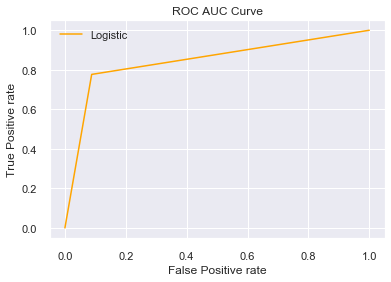

In [178]:
# Metrics for Model 6

confusion_matrix6 = confusion_matrix(y_test,y_pred6)
print("The confusion matrix is: \n", confusion_matrix6)
fpr,tpr,thresholds = roc_curve(y_test,y_pred6)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc6 = roc_auc_score(y_test,y_pred6)
print("The auc score is: ",roc_auc6.round(3))

accuracy6 = accuracy_score(y_test,y_pred6)
print("The accuracy score is: ", accuracy6.round(3))

recall6 = recall_score(y_test,y_pred6)
print("The recall score is: ", recall6.round(3))

precision6 = precision_score(y_test,y_pred6)
print("The precision score is: ", precision6.round(3))

f1_score6 = f1_score(y_test,y_pred6)
print("F1 score is: ", f1_score6.round(3))

# 4.7 Voting Classifier

In [179]:
from sklearn.ensemble import VotingClassifier 
estimators =[('Logistic Regression', model1),('K Nearest Neighbors',model2),('Decision Tree', model3),
             ('Random Forest',model4),('Catboost',model6)]
ensemble = VotingClassifier(estimators)
model7 = ensemble.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)
accuracy_score(y_pred7,y_test)

Learning rate set to 0.066911
0:	learn: 0.6308536	total: 44.3ms	remaining: 44.2s
1:	learn: 0.5828157	total: 97.4ms	remaining: 48.6s
2:	learn: 0.5481606	total: 132ms	remaining: 43.7s
3:	learn: 0.5212109	total: 164ms	remaining: 40.8s
4:	learn: 0.4974051	total: 189ms	remaining: 37.5s
5:	learn: 0.4803762	total: 211ms	remaining: 34.9s
6:	learn: 0.4687820	total: 244ms	remaining: 34.6s
7:	learn: 0.4575745	total: 271ms	remaining: 33.6s
8:	learn: 0.4446505	total: 293ms	remaining: 32.3s
9:	learn: 0.4374845	total: 320ms	remaining: 31.6s
10:	learn: 0.4288887	total: 343ms	remaining: 30.8s
11:	learn: 0.4231571	total: 366ms	remaining: 30.1s
12:	learn: 0.4170923	total: 389ms	remaining: 29.5s
13:	learn: 0.4126870	total: 413ms	remaining: 29.1s
14:	learn: 0.4091269	total: 441ms	remaining: 29s
15:	learn: 0.4058659	total: 464ms	remaining: 28.5s
16:	learn: 0.4024273	total: 488ms	remaining: 28.2s
17:	learn: 0.4002817	total: 528ms	remaining: 28.8s
18:	learn: 0.3967036	total: 570ms	remaining: 29.4s
19:	learn: 

161:	learn: 0.3302721	total: 4.34s	remaining: 22.5s
162:	learn: 0.3301424	total: 4.37s	remaining: 22.4s
163:	learn: 0.3299779	total: 4.39s	remaining: 22.4s
164:	learn: 0.3298093	total: 4.41s	remaining: 22.3s
165:	learn: 0.3295841	total: 4.43s	remaining: 22.3s
166:	learn: 0.3294907	total: 4.45s	remaining: 22.2s
167:	learn: 0.3292972	total: 4.47s	remaining: 22.1s
168:	learn: 0.3291721	total: 4.49s	remaining: 22.1s
169:	learn: 0.3290516	total: 4.52s	remaining: 22.1s
170:	learn: 0.3287510	total: 4.54s	remaining: 22s
171:	learn: 0.3285918	total: 4.56s	remaining: 22s
172:	learn: 0.3284783	total: 4.58s	remaining: 21.9s
173:	learn: 0.3283625	total: 4.6s	remaining: 21.8s
174:	learn: 0.3282254	total: 4.62s	remaining: 21.8s
175:	learn: 0.3280533	total: 4.65s	remaining: 21.8s
176:	learn: 0.3278746	total: 4.68s	remaining: 21.8s
177:	learn: 0.3276731	total: 4.73s	remaining: 21.8s
178:	learn: 0.3275592	total: 4.75s	remaining: 21.8s
179:	learn: 0.3274303	total: 4.78s	remaining: 21.8s
180:	learn: 0.327

321:	learn: 0.3089931	total: 8.41s	remaining: 17.7s
322:	learn: 0.3089523	total: 8.43s	remaining: 17.7s
323:	learn: 0.3089045	total: 8.45s	remaining: 17.6s
324:	learn: 0.3088388	total: 8.47s	remaining: 17.6s
325:	learn: 0.3086562	total: 8.5s	remaining: 17.6s
326:	learn: 0.3085575	total: 8.52s	remaining: 17.5s
327:	learn: 0.3084335	total: 8.55s	remaining: 17.5s
328:	learn: 0.3083089	total: 8.58s	remaining: 17.5s
329:	learn: 0.3082147	total: 8.62s	remaining: 17.5s
330:	learn: 0.3081217	total: 8.64s	remaining: 17.5s
331:	learn: 0.3080320	total: 8.66s	remaining: 17.4s
332:	learn: 0.3079487	total: 8.68s	remaining: 17.4s
333:	learn: 0.3078641	total: 8.7s	remaining: 17.4s
334:	learn: 0.3078265	total: 8.72s	remaining: 17.3s
335:	learn: 0.3077327	total: 8.74s	remaining: 17.3s
336:	learn: 0.3075930	total: 8.77s	remaining: 17.3s
337:	learn: 0.3075154	total: 8.79s	remaining: 17.2s
338:	learn: 0.3074278	total: 8.81s	remaining: 17.2s
339:	learn: 0.3072589	total: 8.84s	remaining: 17.2s
340:	learn: 0.

486:	learn: 0.2951307	total: 12.1s	remaining: 12.7s
487:	learn: 0.2950307	total: 12.1s	remaining: 12.7s
488:	learn: 0.2949175	total: 12.1s	remaining: 12.7s
489:	learn: 0.2948395	total: 12.2s	remaining: 12.7s
490:	learn: 0.2947179	total: 12.2s	remaining: 12.7s
491:	learn: 0.2945939	total: 12.3s	remaining: 12.7s
492:	learn: 0.2945393	total: 12.3s	remaining: 12.6s
493:	learn: 0.2944645	total: 12.3s	remaining: 12.6s
494:	learn: 0.2944138	total: 12.3s	remaining: 12.6s
495:	learn: 0.2943765	total: 12.4s	remaining: 12.6s
496:	learn: 0.2943099	total: 12.4s	remaining: 12.6s
497:	learn: 0.2942445	total: 12.4s	remaining: 12.5s
498:	learn: 0.2942064	total: 12.5s	remaining: 12.5s
499:	learn: 0.2941479	total: 12.5s	remaining: 12.5s
500:	learn: 0.2940786	total: 12.5s	remaining: 12.5s
501:	learn: 0.2940524	total: 12.5s	remaining: 12.4s
502:	learn: 0.2939917	total: 12.5s	remaining: 12.4s
503:	learn: 0.2939318	total: 12.6s	remaining: 12.4s
504:	learn: 0.2938712	total: 12.6s	remaining: 12.3s
505:	learn: 

652:	learn: 0.2842719	total: 16.2s	remaining: 8.6s
653:	learn: 0.2841965	total: 16.2s	remaining: 8.57s
654:	learn: 0.2841451	total: 16.2s	remaining: 8.55s
655:	learn: 0.2840401	total: 16.3s	remaining: 8.52s
656:	learn: 0.2839767	total: 16.3s	remaining: 8.49s
657:	learn: 0.2839331	total: 16.3s	remaining: 8.47s
658:	learn: 0.2838913	total: 16.3s	remaining: 8.44s
659:	learn: 0.2838376	total: 16.3s	remaining: 8.42s
660:	learn: 0.2837945	total: 16.4s	remaining: 8.39s
661:	learn: 0.2837418	total: 16.4s	remaining: 8.37s
662:	learn: 0.2836846	total: 16.4s	remaining: 8.35s
663:	learn: 0.2836375	total: 16.5s	remaining: 8.33s
664:	learn: 0.2835811	total: 16.5s	remaining: 8.31s
665:	learn: 0.2835292	total: 16.5s	remaining: 8.3s
666:	learn: 0.2834884	total: 16.8s	remaining: 8.37s
667:	learn: 0.2834331	total: 16.9s	remaining: 8.39s
668:	learn: 0.2833358	total: 16.9s	remaining: 8.38s
669:	learn: 0.2832561	total: 17.1s	remaining: 8.41s
670:	learn: 0.2831830	total: 17.2s	remaining: 8.43s
671:	learn: 0.

816:	learn: 0.2755390	total: 22.6s	remaining: 5.06s
817:	learn: 0.2754951	total: 22.6s	remaining: 5.03s
818:	learn: 0.2754446	total: 22.6s	remaining: 5s
819:	learn: 0.2753843	total: 22.7s	remaining: 4.98s
820:	learn: 0.2753180	total: 22.7s	remaining: 4.95s
821:	learn: 0.2752806	total: 22.7s	remaining: 4.92s
822:	learn: 0.2752520	total: 22.7s	remaining: 4.89s
823:	learn: 0.2752442	total: 22.8s	remaining: 4.86s
824:	learn: 0.2751778	total: 22.8s	remaining: 4.83s
825:	learn: 0.2751158	total: 22.8s	remaining: 4.81s
826:	learn: 0.2750642	total: 22.9s	remaining: 4.78s
827:	learn: 0.2750253	total: 22.9s	remaining: 4.75s
828:	learn: 0.2749610	total: 22.9s	remaining: 4.72s
829:	learn: 0.2749112	total: 22.9s	remaining: 4.7s
830:	learn: 0.2748679	total: 23s	remaining: 4.67s
831:	learn: 0.2748356	total: 23s	remaining: 4.64s
832:	learn: 0.2747866	total: 23s	remaining: 4.62s
833:	learn: 0.2747490	total: 23.1s	remaining: 4.59s
834:	learn: 0.2747151	total: 23.1s	remaining: 4.57s
835:	learn: 0.2746761	

981:	learn: 0.2681300	total: 27s	remaining: 495ms
982:	learn: 0.2681088	total: 27.1s	remaining: 468ms
983:	learn: 0.2680832	total: 27.1s	remaining: 440ms
984:	learn: 0.2680372	total: 27.1s	remaining: 413ms
985:	learn: 0.2679870	total: 27.1s	remaining: 385ms
986:	learn: 0.2679063	total: 27.2s	remaining: 358ms
987:	learn: 0.2678746	total: 27.2s	remaining: 330ms
988:	learn: 0.2678597	total: 27.2s	remaining: 303ms
989:	learn: 0.2678256	total: 27.2s	remaining: 275ms
990:	learn: 0.2677350	total: 27.3s	remaining: 248ms
991:	learn: 0.2676872	total: 27.3s	remaining: 220ms
992:	learn: 0.2676441	total: 27.3s	remaining: 193ms
993:	learn: 0.2676288	total: 27.3s	remaining: 165ms
994:	learn: 0.2675640	total: 27.4s	remaining: 138ms
995:	learn: 0.2675222	total: 27.4s	remaining: 110ms
996:	learn: 0.2674651	total: 27.4s	remaining: 82.5ms
997:	learn: 0.2674175	total: 27.4s	remaining: 55ms
998:	learn: 0.2673721	total: 27.5s	remaining: 27.5ms
999:	learn: 0.2673262	total: 27.5s	remaining: 0us


0.8796202274573518

The confusion matrix is: 
 [[23002  1802]
 [ 2940 11648]]
The auc score is:  0.863
The accuracy score is:  0.88
The recall score is:  0.798
The precision score is:  0.866
F1 score is:  0.831


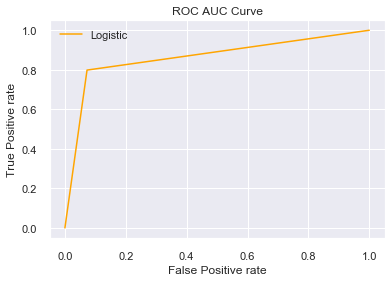

In [180]:
# Metrics for Model 7

confusion_matrix7 = confusion_matrix(y_test,y_pred7)
print("The confusion matrix is: \n", confusion_matrix7)
fpr,tpr,thresholds = roc_curve(y_test,y_pred7)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc7 = roc_auc_score(y_test,y_pred7)
print("The auc score is: ",roc_auc7.round(3))

accuracy7 = accuracy_score(y_test,y_pred7)
print("The accuracy score is: ", accuracy7.round(3))

recall7 = recall_score(y_test,y_pred7)
print("The recall score is: ", recall7.round(3))

precision7 = precision_score(y_test,y_pred7)
print("The precision score is: ", precision7.round(3))

f1_score7 = f1_score(y_test,y_pred7)
print("F1 score is: ", f1_score7.round(3))

# 4.8 Model comparaison

In [181]:
pd.DataFrame({
    "Model": ["Logistic Regression", "K Nearest Neighbors","Decision Tree", 
              "Random Forest","Naive Bayes","Catboost","Voting Classifier"],
    "Roc Auc": [eval(f'roc_auc{i}') for i in range(1,8)],
    "Accuracy": [eval(f'accuracy{i}') for i in range(1,8)],
    "Recall": [eval(f'recall{i}') for i in range(1,8)],
    "Precision": [eval(f'precision{i}') for i in range(1,8)],
    "F1 score": [eval(f'f1_score{i}') for i in range(1,8)],
}).round(3)

,Model,Roc Auc,Accuracy,Recall,Precision,F1 score
0,Logistic Regression,0.759,0.771,0.713,0.683,0.698
1,K Nearest Neighbors,0.812,0.833,0.734,0.798,0.765
2,Decision Tree,0.830,0.841,0.786,0.786,0.786
3,Random Forest,0.861,0.879,0.792,0.869,0.829
4,Naive Bayes,0.637,0.578,0.864,0.463,0.602
5,Catboost,0.844,0.862,0.777,0.839,0.806
6,Voting Classifier,0.863,0.880,0.798,0.866,0.831


The best model regarding the ROC AUC score is the Random Forest but regarding the precision score it is our Ensemble model.
Since we know that Random forest tends to overfit, we will keep the 'Ensemble' as our final model.

# 5. Summary

# 5.1 Analysing Random forest contributions from features

In [182]:
feature_importances = pd.DataFrame(model4.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)

,importance
lead_time,0.159295
deposit_type_Non Refund,0.111141
adr,0.108388
client_cluster,0.103267
arrival_date_week_number,0.078582
arrival_date_day_of_month,0.074996
total_of_special_requests,0.065292
stays_in_week_nights,0.046390
customer_type_Transient,0.028887
stays_in_weekend_nights,0.028484


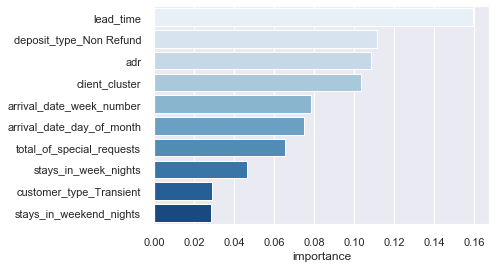

In [183]:
sns.barplot( x=feature_importances.importance.head(10) ,y=feature_importances.head(10).index, data=feature_importances.head(10), palette='Blues')

# 5.2 Conclusion

RESULTS
- With the Voting Classifier model, we are able to predict a booking cancellation by 86%
- Voting Classifier works well and guarantees us a model that will tend to be less over-fitted than the Random Tree Classifier 
- While we weren't confident about our clusters, it turns out to be the 4th most important feature for predicting a cancellation 

DIFFICULTY
- Hard to see the result of our clustering and understand what the model did

IMPROVMENTS
- Building a more universal model getting more data from various hotels
- Building a more specialized model with better results focusing only on a specific hotel
